In [1]:
!git init
!git add BENNETT-George_ENGI4607.ipynb
!git commit -m "Initial commit"
!git remote add origin https://github.com/George-Bennett-145/AI-and-Deep-Learning-Applications
!git push -u origin master

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
fatal: pathspec 'BENNETT-George_ENGI4607.ipynb' did not match any files
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@8510282dacff.(none)')
error: src refspec master does not match any
error: faile

# Data Processing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
filepath = '/content/drive/My Drive/AI Coursework/Biomarker_Clinical_Data_Images_2.csv'
Data = pd.read_csv(filepath)
Data.columns = Data.columns.str.strip()
Data.head()

# Task 1: Supervised Machine Learning, Visualisation, and Feature Importance

## 1-1. Visualisation

   Biomarker 1  Biomarker 2  Biomarker 3  Biomarker 4  Biomarker 5  \
0            0            0            0            0            1   
1            0            1            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   Biomarker 6  Biomarker 7  Biomarker 8  Biomarker 9  Biomarker 10  \
0            0            1            0            0             0   
1            0            1            0            0             0   
2            0            1            0            0             0   
3            0            0            0            1             0   
4            1            0            0            0             0   

   Biomarker 11  Biomarker 12  Biomarker 13  Biomarker 14  Biomarker 15  \
0             1             1             1             0             0   
1 

Text(0, 0.5, 'cumulative explained variance')

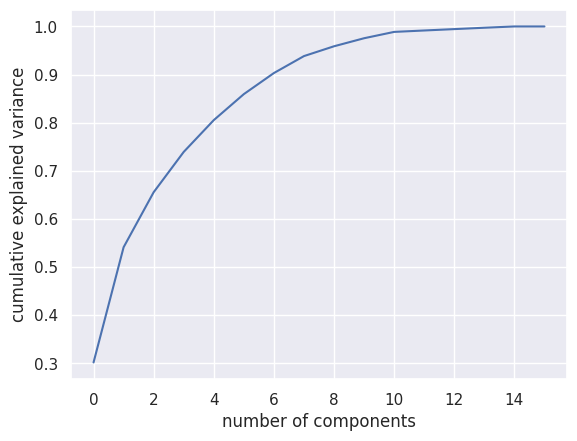

In [ ]:
VD = Data.iloc[:,1:17]
print(VD.head())
pca = PCA().fit(VD)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

## 1-2. Selecting Models

### Only Biomarkers - SVM

In [ ]:
### Only Biomarkers ###
X = Data.drop(['Path','BCVA','CST','Disease Label','Eye_ID'], axis = 1)
Y = Data['Disease Label']
groups = Data['Eye_ID']
group_splitter = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(group_splitter.split(X, Y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

# Verify the splitting integrity (each Eye_ID should be in only one of the splits)
train_eye_ids = set(Data["Eye_ID"].iloc[train_idx])
test_eye_ids = set(Data["Eye_ID"].iloc[test_idx])
overlap = train_eye_ids.intersection(test_eye_ids)

# Outputs for verification
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Overlap in Eye_ID between training and testing sets:", len(overlap))







Training set shape: (134, 16)
Testing set shape: (58, 16)
Overlap in Eye_ID between training and testing sets: 0


In [ ]:
kernels = 'linear', 'poly', 'rbf', 'sigmoid'
for kernel in kernels:
  if kernel == 'poly':
    svm = SVC(kernel=kernel,degree = 1,random_state=42)
  elif kernel == 'rbf':
    svm = SVC(kernel=kernel,gamma = 'scale', C= 0.7,random_state=42)
  else:
    svm = SVC(kernel=kernel,random_state=42)

  svm.fit(X_train, Y_train)


  # Step 3: Make predictions
  Y_pred = svm.predict(X_test)

  # Step 4: Generate the classification report
  report = classification_report(Y_test, Y_pred, target_names=Y_test.unique())
  print(report)

              precision    recall  f1-score   support

         DME       0.90      0.75      0.82        36
          DR       0.68      0.86      0.76        22

    accuracy                           0.79        58
   macro avg       0.79      0.81      0.79        58
weighted avg       0.82      0.79      0.80        58

              precision    recall  f1-score   support

         DME       0.90      0.75      0.82        36
          DR       0.68      0.86      0.76        22

    accuracy                           0.79        58
   macro avg       0.79      0.81      0.79        58
weighted avg       0.82      0.79      0.80        58

              precision    recall  f1-score   support

         DME       0.91      0.81      0.85        36
          DR       0.73      0.86      0.79        22

    accuracy                           0.83        58
   macro avg       0.82      0.83      0.82        58
weighted avg       0.84      0.83      0.83        58

              preci

### Only Clinical Labels - SVM

In [ ]:
X = Data[['BCVA','CST']]
Y = Data['Disease Label']
groups = Data['Eye_ID']
group_splitter = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(group_splitter.split(X, Y, groups))

### Combined - SVM

In [ ]:
X = Data.iloc[:,list(range(1,17)) + list(range(18,20))]
print(X.head())
Y = Data['Disease Label']
groups = Data['Eye_ID']
group_splitter = GroupShuffleSplit(test_size=0.3, random_state=42)
train_idx, test_idx = next(group_splitter.split(X, Y, groups))


   Biomarker 1  Biomarker 2  Biomarker 3  Biomarker 4  Biomarker 5  \
0            0            0            0            0            1   
1            0            1            0            0            1   
2            0            0            0            0            1   
3            0            0            0            0            1   
4            0            0            0            0            1   

   Biomarker 6  Biomarker 7  Biomarker 8  Biomarker 9  Biomarker 10  \
0            0            1            0            0             0   
1            0            1            0            0             0   
2            0            1            0            0             0   
3            0            0            0            1             0   
4            1            0            0            0             0   

   Biomarker 11  Biomarker 12  Biomarker 13  Biomarker 14  Biomarker 15  \
0             1             1             1             0             0   
1 

## 1-3. Model Comparison

## 1-4. Evaluation of Feature Importance

# Task 2: Convolutional Neural Network (CNN) for Disease Classification and Data Augmentation




## 2-1. Network Design and Hyperparameter Optimization

## 2-2. Data Augmentation

## 2-3. Performance Analysis and Metrics

## 2-4. Fine-Tuning with Pre-trained Model


# Task 3: Integrating Clinical Labels, Biomarkers, and OCT Images

## 3-1. Feature Fusion with CNN


## 3-2. Ensemble Learning: